лиганд 
https://zinc15.docking.org/substances/ZINC000002033385/

ZINC2033385
N[C@@H](CCCc1ccc(N(CCCl)CCCl)cc1)C(=O)O

Трипсин белок
https://www.rcsb.org/structure/1TNG (c CAL, но без лигандов)




### Удаление ненужного из pdb белка

In [5]:
import pypdb
import nglview as nv
import MDAnalysis as mda

file_name = 'protein.pdb'
molecule=mda.Universe(file_name)

file_name = 'prot_and_CA.pdb'
protein=molecule.select_atoms('protein or resname CA')
protein.write(file_name)
file_name

C:\Programing\Miniconda\envs\struct_bioinf\lib\site-packages\MDAnalysis\topology\base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)
C:\Programing\Miniconda\envs\struct_bioinf\lib\site-packages\MDAnalysis\topology\PDBParser.py:426: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the 

'prot_and_CA.pdb'

### После параметризации и просчёта МД на громаксе

In [7]:
model=mda.Universe(f'3 from gromacs\hw4_2\step5_production.gro',f'3 from gromacs\hw4_2\step5_production.xtc')

In [11]:
print(len(model.select_atoms('protein')))
print(len(model.select_atoms('resname SOL')))
print(len(model.select_atoms('resname LIG')))
print(len(model.select_atoms('resname TIP3')))
print(len(model.select_atoms('name CAL')))

3222
52566
43
0
1


In [12]:
view=nv.show_mdanalysis(model)
view

NGLWidget(max_frame=40)

In [14]:
view.add_spacefill('CAL')
view.add_spacefill('TIP3',opacity=0.05)
view.add_unitcell()

# RMSD fitting and analysis

In [15]:
from MDAnalysis.analysis import rms
import pandas as pd

In [16]:
BACKBONE = 'backbone'
SIDECHAINS = 'not backbone'

In [17]:

#среднее квадр отклонение относительно нулевого кадра 
R = rms.RMSD(model,  # universe to align
             model,  # reference universe or atomgroup
             select='backbone',  # group to superimpose and calculate RMSD
             groupselections=[BACKBONE, SIDECHAINS],  # groups for RMSD
             ref_frame=0)  # frame index of the reference
R.run()

In [18]:
df = pd.DataFrame(R.rmsd,
                  columns=['Frame', 'Time (ps)',
                           'Total', 'backbone',
                           'sidechains'])

<AxesSubplot:xlabel='Frame'>

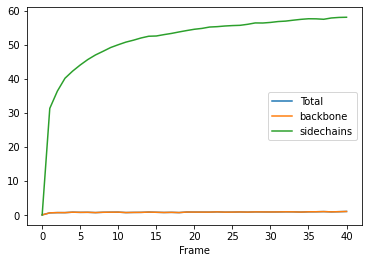

In [19]:
df.plot(x='Frame', y=['Total', 'backbone', 'sidechains'],
             kind='line')

<AxesSubplot:xlabel='Frame'>

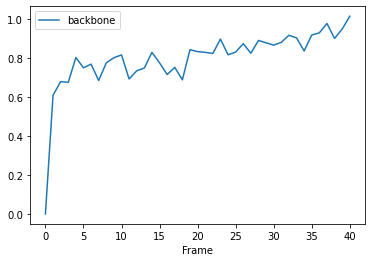

In [20]:
df.plot(x='Frame', y=['backbone'],
             kind='line')

# checking for compactness

In [21]:
prot = model.select_atoms("protein")
Rgyr=[]
for ts in model.trajectory[::1]:
    Rgyr.append(prot.radius_of_gyration())

In [22]:
df['Rgyr']=Rgyr

<AxesSubplot:xlabel='Frame'>

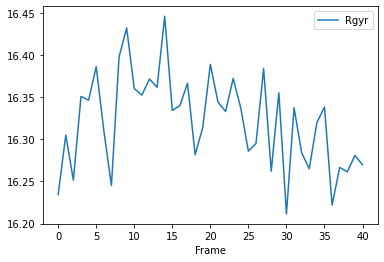

In [23]:
df.plot(x='Frame', y=['Rgyr'],
             kind='line')

# RMSF fitting and analysis

In [24]:
from MDAnalysis.analysis import align

#фиксируем белок
prealigner = align.AlignTraj(model, model, select="protein and name CA",
                             in_memory=True).run()

#rmsfer = RMSF(calphas).run()

C:\Programing\Miniconda\envs\struct_bioinf\lib\site-packages\MDAnalysis\core\selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)


In [25]:
view=nv.show_mdanalysis(model)
#убрать воду 
view.add_spacefill('TIP3',opacity=0.05)
view.add_spacefill('CAL')

view

NGLWidget(max_frame=40)

In [26]:
#расчёт средне кв флуктуаций

rmsf_runner=rms.RMSF(model.select_atoms('protein and name CA'), verbose=True).run()

C:\Programing\Miniconda\envs\struct_bioinf\lib\site-packages\MDAnalysis\core\selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)
100%|██████████| 41/41 [00:00<00:00, 5869.76it/s]


In [27]:
seq_3_base=model.select_atoms('protein').residues.resnames

In [28]:
rmsf_result=pd.DataFrame(rmsf_runner.rmsf,index=seq_3_base)

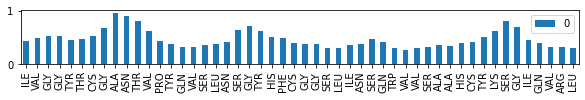

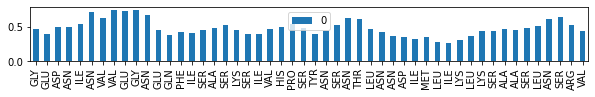

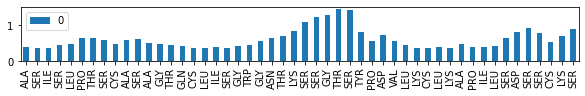

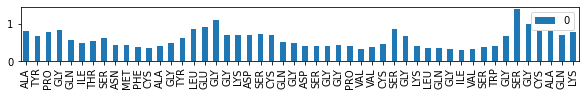

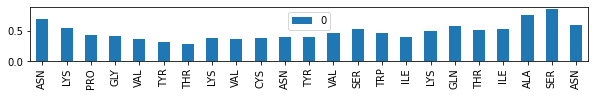

In [29]:
#где подвижность в белке
step=50
for i in range(0,len(seq_3_base),step):
    rmsf_result.iloc[i:i+step].plot(kind='bar',figsize=(10,1))

<AxesSubplot:>

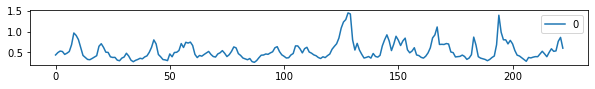

In [30]:
rmsf_result.plot(kind='line',figsize=(10,1),use_index =False)

# visualize RMSF

In [31]:
protein_residues=model.select_atoms('protein').residues
model.add_TopologyAttr('tempfactors')

In [32]:
for residue,RMSF_value in zip(protein_residues,rmsf_runner.rmsf):
    residue.atoms.tempfactors=RMSF_value

In [37]:
view=nv.show_mdanalysis(model)
view

NGLWidget(max_frame=40)

In [35]:
#отображение подвижности петлей
view.update_cartoon(color='bfactor')
view


NGLWidget(max_frame=40, n_components=1)


лиганд 
https://zinc15.docking.org/substances/ZINC000002033385/

ZINC2033385
N[C@@H](CCCc1ccc(N(CCCl)CCCl)cc1)C(=O)O

Трипсин белок
https://www.rcsb.org/structure/1TNG (c CAL, но без лигандов)





выводы:
- состояние самого белка, структура, и положение CAL не меняется при добавлении лиганда
- судя по графикам система приходит в равновесие -- можно больше расчитать МД
- лиганд вроде бы как стремится занять стабильное состояние и залезть в белок
- для количества трудностей и костылей, с которыми пришлось столкнуться, всё выглядит очень даже красиво

Спасибо за курс!